## Finite state space example

现在在我们已知 $(M_t, I_t, S_t)$, 要估计fair price。为了对离散过程进行建模同时减少计算量，我们进行以下处理：

1. 我们把 $I_t$ 分为 n 段，每一段的表示为如下公式。比如说[1，2，3，4，5]分别表示imbalance程度为[0-0.2, 0.2-0.4, 0.4-0.6, 0.6-0.8, 0.8-1.0]：
$$
I_t=\sum_{j=1}^nj\mathbb{1}_{\left(\frac{j-1}{n}<\frac{Q_t^b}{Q_t^b+Q_t^a}\leq\frac{j}{n}\right)}
$$

2. 同时 spread 的值为离散值，服从 1<= s <= m

所以状态 $(I_t, S_t)$ 为离散值，且取值有 nm 个。

3. 我们使用$K=\begin{bmatrix}-0.01,-0.005,0.005,0.01\end{bmatrix}^T$来表示 mid-price 的变动，（或者取值为 -1个tick，-0.5个tick， 0.5个tick， 1个tick）

则对于下一个时刻的 mid-price 的变动来说，服从以下的公式：

$$\begin{aligned}
G^{1}(x)& =\mathbb{E}\left[M_{\tau_{1}}-M_{t}|X_{t}=x\right]  \\
&= \sum_{k\in K}k\cdot\mathbb{P}(M_{\tau_{1}}-M_{t}=k|X_{t}=x)  \\
&=\sum_{k\in K}\sum_{u}k\cdot\mathbb{P}(M_{\tau_{1}}-M_{t}=k\wedge\tau_{1}-t=u|X_{t}=x)
\end{aligned}$$

我们估计两种状态：
1. R := absorbing states, 可以理解为在给定 $(I_t, S_t)$ 下，mid-price发生改变k的概率，其中k是上文中定义的K的取值。所以矩阵的维度是 4 x nm
$$R_{xk}:=\mathbb{P}(M_{t+1}-M_t=k|X_t=x)$$


2. Q :=  transient states, 可以理解为在给定 $x = (I_t, S_t)$ 下，mid-price 不发生改变且下一个状态是新的$y = (I_t, S_t)$ 的概率。所以矩阵的维度是 nm x nm
$$Q_{xy}:=\mathbb{P}(M_{t+1}-M_t=0\wedge X_{t+1}=y|X_t=x)$$

所以下一个时刻，mid-price 发生改变的期望是：
$$G^1(x)=\bigl(\sum_sQ^{s-1}R\bigr)K=\bigl(1-Q\bigr)^{-1}RK$$

通过递归我们就可以算出来$G^{i+1}(x)$


### 最终公式

为了方便计算，我们重新定义 absorbing states T, 新的矩阵维度是 nm x nm:
$$T_{xy}:=\mathbb{P}(M_{t+1}-M_t\neq0\wedge X_{t+1}=y|X_t=x)$$

定义$B:=\left(1-Q\right)^{-1}T$， B 显然是一个 nm x nm 的矩阵。则最终的价格为：
$$P_t^i=M_t+\sum_{k=0}^iB^kG^1$$

THEOREM $3.1\quad If\:B^*=\lim_{k\to\infty}B^k\:and\:B^*G^1=0,\:then\:the\:limit$
$\lim_{i\to\infty}P_{t}^{i}=P_{t}^{micro}$
$converges.$

The matrix $B$ is a regular stochastic matrix so it can be decomposed

$$
B=B^*+\sum_{j=2}^{nm}\lambda_jB_j
$$

所以最终的公式为：

$$P_t^{micro}=\lim\limits_{i\to\infty}P_t^i=M_t+G^1+\sum\limits_{j=2}^{nm}\frac{\lambda_j}{1-\lambda_j}B_jG^1$$



# 计算步骤
1. symmetrize data
    - (It,St,It+1,St+1,dM) ==> (1-It,St,1-It+1,St+1,-dM)
2. Estimate Q, T, R
3. Calculate G1
4. Calculate G* ==> micro price adjustment 


In [1]:
# load libraries 
import math
import decimal 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from scipy.linalg import block_diag
from scipy.linalg import eig

from StoikovEstimator import processing_data, estimate_transi_prob, f_cal_G6, get_default_K, estimate_old

# load data
df_data = pd.read_parquet('../Data/20240310/eth_usdt_binance_LOB.parquet')
df_data.columns = ['time_seconds', 'ask_price', 'ask_size', 'bid_price', 'bid_size']
# df_data['time_seconds'] = ((df_data.time_seconds)/1000 +1).astype(int)
# df_data = df_data.drop_duplicates(subset=['time_seconds'],keep='last').reset_index(drop=True)

test_percentage = 0.4
df_data_test = df_data.iloc[-int(test_percentage*len(df_data.time_seconds)):,].reset_index(drop=True)
df_data = df_data.iloc[:-len(df_data_test),].reset_index(drop=True)


# hyper-parameter
# number of imbalance 
n_imb = 11
# number of spread 
n_spread = 2
# delta t 
dt = 10

# grid of mid price change [half tick, one tick]
# K = np.array([-0.00001, -0.000005, 0.000005, 0.00001])
K = get_default_K(df_data)
print("K is", K)

K is [-0.01  -0.005  0.005  0.01 ]


### 使用过去的数据估计参数

In [2]:
# processing data 
df_data_to_use = processing_data(df_data, n_imb, n_spread, dt)

# estimation of transition probabiliies
G1,B,Q,Q2,R1,R2 = estimate_transi_prob(df_data_to_use, K, n_imb, n_spread)

# calculate micro price 
G6 = f_cal_G6(G1, B)
df_data_to_use

tick_size is 0.01


,time_seconds,ask_price,ask_size,bid_price,bid_size,spread,mid,wmid,imb,imb_bucket,next_mid,next_wmid,next_spread,next_imb_bucket,dM,dwM
0,1710003600000,3884.45,66.8428,3884.44,15.5300,0.01,3884.445,3884.441885,0.188533,3,3884.445,3884.441932,0.01,3.0,0.0,0.0
1,1710003600000,3884.45,66.8428,3884.44,15.5084,0.01,3884.445,3884.441883,0.188320,3,3884.445,3884.441982,0.01,3.0,0.0,0.0
2,1710003600006,3884.45,66.8319,3884.44,15.5084,0.01,3884.445,3884.441883,0.188345,3,3884.445,3884.441982,0.01,3.0,0.0,0.0
3,1710003600009,3884.45,66.8155,3884.44,15.5084,0.01,3884.445,3884.441884,0.188383,3,3884.445,3884.441983,0.01,3.0,0.0,0.0
4,1710003600011,3884.45,66.8035,3884.44,15.5084,0.01,3884.445,3884.441884,0.188410,3,3884.445,3884.442204,0.01,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595864,1710064283940,3947.80,7.0000,3947.79,1.3974,0.01,3947.795,3947.791664,0.166409,7,3947.795,3947.790524,0.01,8.0,-0.0,-0.0
2595865,1710064283940,3947.80,9.9000,3947.79,1.3974,0.01,3947.795,3947.791237,0.123692,8,3947.795,3947.790448,0.01,9.0,-0.0,-0.0
2595866,1710064283940,3947.80,9.9000,3947.79,1.3793,0.01,3947.795,3947.791223,0.122286,8,3947.795,3947.790431,0.01,9.0,-0.0,-0.0
2595867,1710064283940,3947.80,13.2426,3947.79,1.3793,0.01,3947.795,3947.790943,0.094331,8,3947.795,3947.790393,0.01,9.0,-0.0,-0.0


<Figure size 1040x480 with 0 Axes>

Text(0.5, 1.0, 'microprice adjustment')

Text(0.5, 0, 'Imbalance')

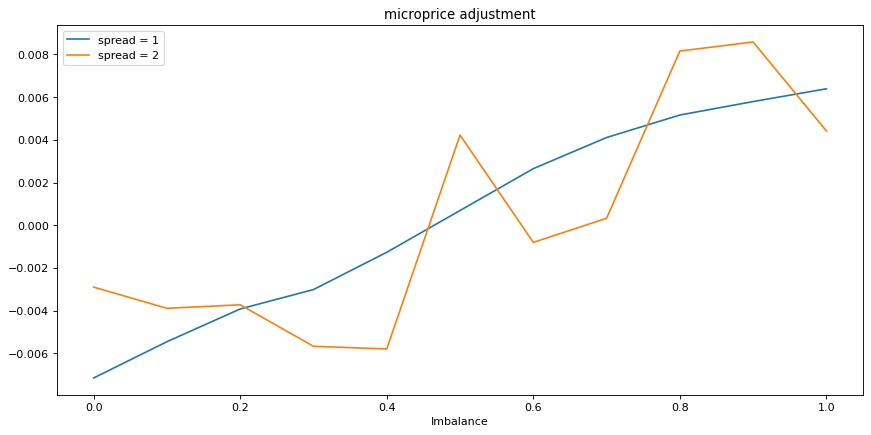

In [3]:
# plot 
imb=np.linspace(0,1,n_imb)
plt.figure(figsize=(13, 6), dpi=80)
for i in range(0,n_spread):
    plt.plot(imb,G6[(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1))
# plt.ylim(-0.005,0.005)
plt.legend(loc='upper left')
plt.title('microprice adjustment')
plt.xlabel('Imbalance')

In [4]:
G6

array([-0.00715299, -0.00545376, -0.00392078, -0.00301264, -0.00126639,
        0.0006889 ,  0.00264887,  0.00410649,  0.00515986,  0.00579068,
        0.00638759, -0.00289795, -0.00389078, -0.00372613, -0.00566921,
       -0.00579306,  0.00422052, -0.00080274,  0.00032478,  0.00815675,
        0.00858067,  0.00441525])

### out of sample test   

In [5]:
# processing data 
df_data_test_to_use = processing_data(df_data_test, n_imb, n_spread, dt, is_filter_symm=False)

# 记录需要的调整
spread1_adjustment = dict((i,G6[i]) for i in range(n_imb))
spread2_adjustment = dict((i,G6[i+11]) for i in range(n_imb))

df_data_test_to_use['micro_adj'] = df_data_test_to_use.loc[df_data_test_to_use.spread==1*K[3],].imb_bucket.map(spread1_adjustment)
df_data_test_to_use['micro_price'] = df_data_test_to_use['mid'] + df_data_test_to_use['micro_adj']
valid_test = df_data_test_to_use.loc[df_data_test_to_use.micro_price.notna(),]
valid_test = valid_test.drop_duplicates(subset=['time_seconds'],keep='last').reset_index(drop=True)

valid_test

tick_size is 0.01


,time_seconds,ask_price,ask_size,bid_price,bid_size,spread,mid,wmid,imb,imb_bucket,next_mid,next_wmid,next_spread,next_imb_bucket,dM,dwM,micro_adj,micro_price
0,1710064283940,3947.80,32.1868,3947.79,1.2713,0.01,3947.795,3947.790380,0.037997,1,3947.795,3947.790614,0.01,2.0,0.0,0.0,-0.005454,3947.789546
1,1710064283941,3947.80,57.7412,3947.79,1.2713,0.01,3947.795,3947.790215,0.021543,1,3947.795,3947.791853,0.01,3.0,0.0,0.0,-0.005454,3947.789546
2,1710064283942,3947.80,52.7241,3947.79,3.3853,0.01,3947.795,3947.790603,0.060334,2,3947.795,3947.791195,0.01,2.0,0.0,0.0,-0.003921,3947.791079
3,1710064283943,3947.80,52.7241,3947.79,12.7853,0.01,3947.795,3947.791952,0.195167,3,3947.795,3947.791191,0.01,2.0,0.0,-0.0,-0.003013,3947.791987
4,1710064283944,3947.80,54.2251,3947.79,12.7853,0.01,3947.795,3947.791908,0.190796,3,3947.795,3947.791188,0.01,2.0,0.0,-0.0,-0.003013,3947.791987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926375,1710089999987,3904.56,14.7514,3904.55,64.6621,0.01,3904.555,3904.558142,0.814246,7,NaN,NaN,NaN,NaN,NaN,NaN,0.004106,3904.559106
926376,1710089999988,3904.56,14.7413,3904.55,64.6621,0.01,3904.555,3904.558143,0.814349,7,NaN,NaN,NaN,NaN,NaN,NaN,0.004106,3904.559106
926377,1710089999989,3904.56,14.7326,3904.55,64.6484,0.01,3904.555,3904.558144,0.814406,7,NaN,NaN,NaN,NaN,NaN,NaN,0.004106,3904.559106
926378,1710089999993,3904.56,14.7106,3904.55,64.6484,0.01,3904.555,3904.558146,0.814632,7,NaN,NaN,NaN,NaN,NaN,NaN,0.004106,3904.559106


In [6]:
# 500ms 后的预测效果
valid_test['future_price'] = valid_test.mid.shift(-500)

score_mid = (valid_test.future_price - valid_test.mid).abs().mean()
score_wmid = (valid_test.future_price - valid_test.wmid).abs().mean()
score_micro_price = (valid_test.future_price - valid_test.micro_price).abs().mean()

print("mse of mid:", score_mid)
print("mse of wmid:", score_wmid)
print("mse of micro-price:", score_micro_price)

print('improve of wmid to mid:', score_mid - score_wmid)
print('improve of micro to wmid:', score_wmid - score_micro_price)

mse of mid: 0.9848284010886906
mse of wmid: 0.9840608455939293
mse of micro-price: 0.9839483723859671
improve of wmid to mid: 0.0007675554947613739
improve of wmid to mid: 0.00011247320796214932


In [7]:
# 1s 后的预测效果
valid_test['future_price'] = valid_test.mid.shift(-1000)

score_mid = (valid_test.future_price - valid_test.mid).abs().mean()
score_wmid = (valid_test.future_price - valid_test.wmid).abs().mean()
score_micro_price = (valid_test.future_price - valid_test.micro_price).abs().mean()

print("mse of mid:", score_mid)
print("mse of wmid:", score_wmid)
print("mse of micro-price:", score_micro_price)

print('improve of wmid to mid:', score_mid - score_wmid)
print('improve of micro to wmid:', score_wmid - score_micro_price)

mse of mid: 1.4197155546910436
mse of wmid: 1.4192335937507081
mse of micro-price: 1.4191710273184133
improve of wmid to mid: 0.00048196094033547965
improve of wmid to mid: 6.25664322948527e-05


In [8]:
# 3s 后的预测效果
valid_test['future_price'] = valid_test.mid.shift(-3000)

score_mid = (valid_test.future_price - valid_test.mid).abs().mean()
score_wmid = (valid_test.future_price - valid_test.wmid).abs().mean()
score_micro_price = (valid_test.future_price - valid_test.micro_price).abs().mean()

print("mse of mid:", score_mid)
print("mse of wmid:", score_wmid)
print("mse of micro-price:", score_micro_price)

print('improve of wmid to mid:', score_mid - score_wmid)
print('improve of micro to wmid:', score_wmid - score_micro_price)

mse of mid: 2.4473058329181927
mse of wmid: 2.4470172761420517
mse of micro-price: 2.446990258113793
improve of wmid to mid: 0.0002885567761410357
improve of wmid to mid: 2.701802825866295e-05
